# Task 2: Bayesian Change Point Analysis of Brent Oil Prices

**Objective**: Apply Bayesian change point detection to identify and quantify structural breaks in Brent oil prices, then associate detected changes with major geopolitical and economic events.

---

## Overview

This notebook implements:
1. **Data Preparation & EDA**: Load data, compute log returns, visualize price trends
2. **Bayesian Change Point Model**: Build and run PyMC model with discrete switch point
3. **Model Diagnostics**: Check convergence, interpret posterior distributions
4. **Event Association**: Map detected change points to structured events dataset
5. **Impact Quantification**: Provide probabilistic statements about regime shifts

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


PyMC version: 5.27.1
ArviZ version: 0.23.4


In [2]:
# Load processed Brent price data
df = pd.read_csv('../data/processed_brent_prices_2014_2022.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"Data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
df.head()

Data shape: (2259, 10)
Date range: 2014-01-02 00:00:00 to 2022-11-14 00:00:00


,Date,Price,MA_30,MA_90,MA_365,Log_Price,Log_Returns,Simple_Returns,Volatility_30,Volatility_90
0,2014-01-02,107.94,110.563667,110.077222,109.299507,4.681576,-0.018450,-0.018281,0.009900,0.010982
1,2014-01-03,106.57,110.506333,110.014333,109.307726,4.668802,-0.012773,-0.012692,0.010132,0.011058
2,2014-01-06,106.71,110.454333,109.919889,109.319671,4.670115,0.001313,0.001314,0.010137,0.010686
3,2014-01-07,107.01,110.358000,109.817000,109.325808,4.672922,0.002807,0.002811,0.009735,0.010640
4,2014-01-08,107.42,110.226667,109.711556,109.328877,4.676746,0.003824,0.003831,0.009412,0.010630


In [3]:
# Load structured events dataset
events_df = pd.read_csv('../data/structured_events.csv')
events_df['Date'] = pd.to_datetime(events_df['Date'])
events_df = events_df.sort_values('Date').reset_index(drop=True)

print(f"Number of events: {len(events_df)}")
events_df.head(10)

Number of events: 15


,Date,Event_Type,Description,Expected_Impact
0,2014-11-27,OPEC_Decision,OPEC decides not to cut production despite fal...,Supply_Negative
1,2015-01-15,Economic_Shock,Continued global oversupply signals and China ...,Demand_Negative
2,2016-11-30,OPEC_Decision,OPEC agrees to cut production by 1.2M bpd (fir...,Supply_Positive
3,2018-05-08,Geopolitical,U.S. withdraws from Iran nuclear deal; reimpos...,Supply_Positive
4,2019-09-14,Geopolitical,Attacks on Saudi Aramco facilities at Abqaiq a...,Supply_Positive
5,2020-03-06,OPEC_Decision,Russia-Saudi price war begins; OPEC+ fails to ...,Supply_Negative
6,2020-03-11,Economic_Shock,COVID-19 declared pandemic; global demand coll...,Demand_Negative
7,2020-04-12,OPEC_Decision,OPEC+ agrees to historic production cuts of 9....,Supply_Positive
8,2020-04-20,Economic_Shock,WTI futures contract goes negative; storage ca...,Demand_Negative
9,2021-07-01,Economic_Shock,Demand recovery amid Delta variant concerns; O...,Mixed


In [4]:
# Create output directory for saving figures
import os
output_dir = '../reports/figures'
os.makedirs(output_dir, exist_ok=True)
print(f"✓ Output directory created: {output_dir}")

✓ Output directory created: ../reports/figures


## 2. Data Preparation and Exploratory Analysis

In [5]:
# Compute log returns: log(price_t) - log(price_{t-1})
df['log_price'] = np.log(df['Price'])
df['log_return'] = df['log_price'].diff()

# Drop the first NaN value from log_return
df = df.dropna().reset_index(drop=True)

print(f"Log returns computed. Shape: {df.shape}")
print(f"\nLog returns summary statistics:")
print(df['log_return'].describe())

Log returns computed. Shape: (2258, 12)

Log returns summary statistics:
count    2258.000000
mean       -0.000063
std         0.032026
min        -0.643699
25%        -0.011145
50%         0.000603
75%         0.012063
max         0.412023
Name: log_return, dtype: float64


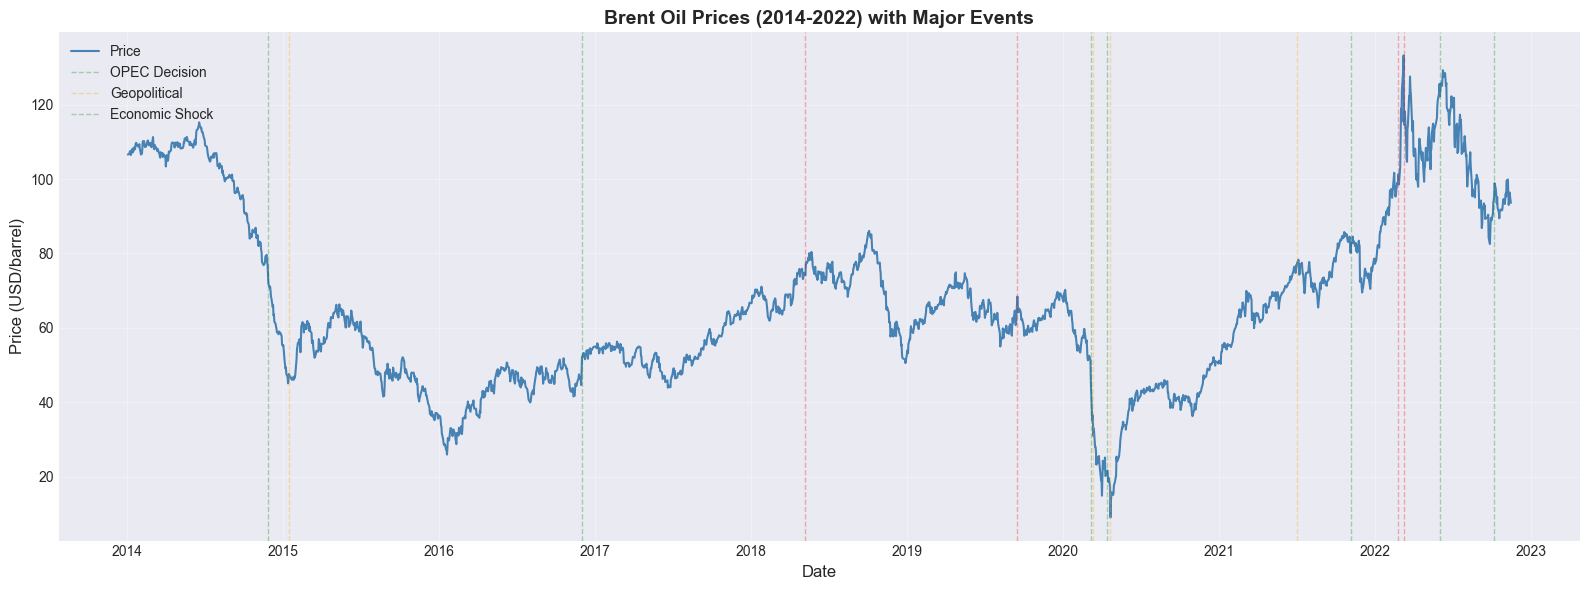


✓ Figure saved: 01_price_series_with_events.png

Key observations:
- Clear 2014-2016 price decline
- Dramatic 2020 pandemic shock (March-April 2020)
- 2021-2022 price surge following Ukraine invasion


In [6]:
# Plot raw price series with event markers
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df['Date'], df['Price'], linewidth=1.5, color='steelblue', label='Brent Price')

# Add vertical lines for major events
for idx, row in events_df.iterrows():
    event_type = row['Event_Type']
    color = {'OPEC_Decision': 'green', 'Geopolitical': 'red', 'Economic_Shock': 'orange'}.get(event_type, 'gray')
    ax.axvline(row['Date'], color=color, alpha=0.3, linestyle='--', linewidth=1)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD/barrel)', fontsize=12)
ax.set_title('Brent Oil Prices (2014-2022) with Major Events', fontsize=14, fontweight='bold')
ax.legend(['Price', 'OPEC Decision', 'Geopolitical', 'Economic Shock'], loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/01_price_series_with_events.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: 01_price_series_with_events.png")
print("\nKey observations:")
print("- Clear 2014-2016 price decline")
print("- Dramatic 2020 pandemic shock (March-April 2020)")
print("- 2021-2022 price surge following Ukraine invasion")

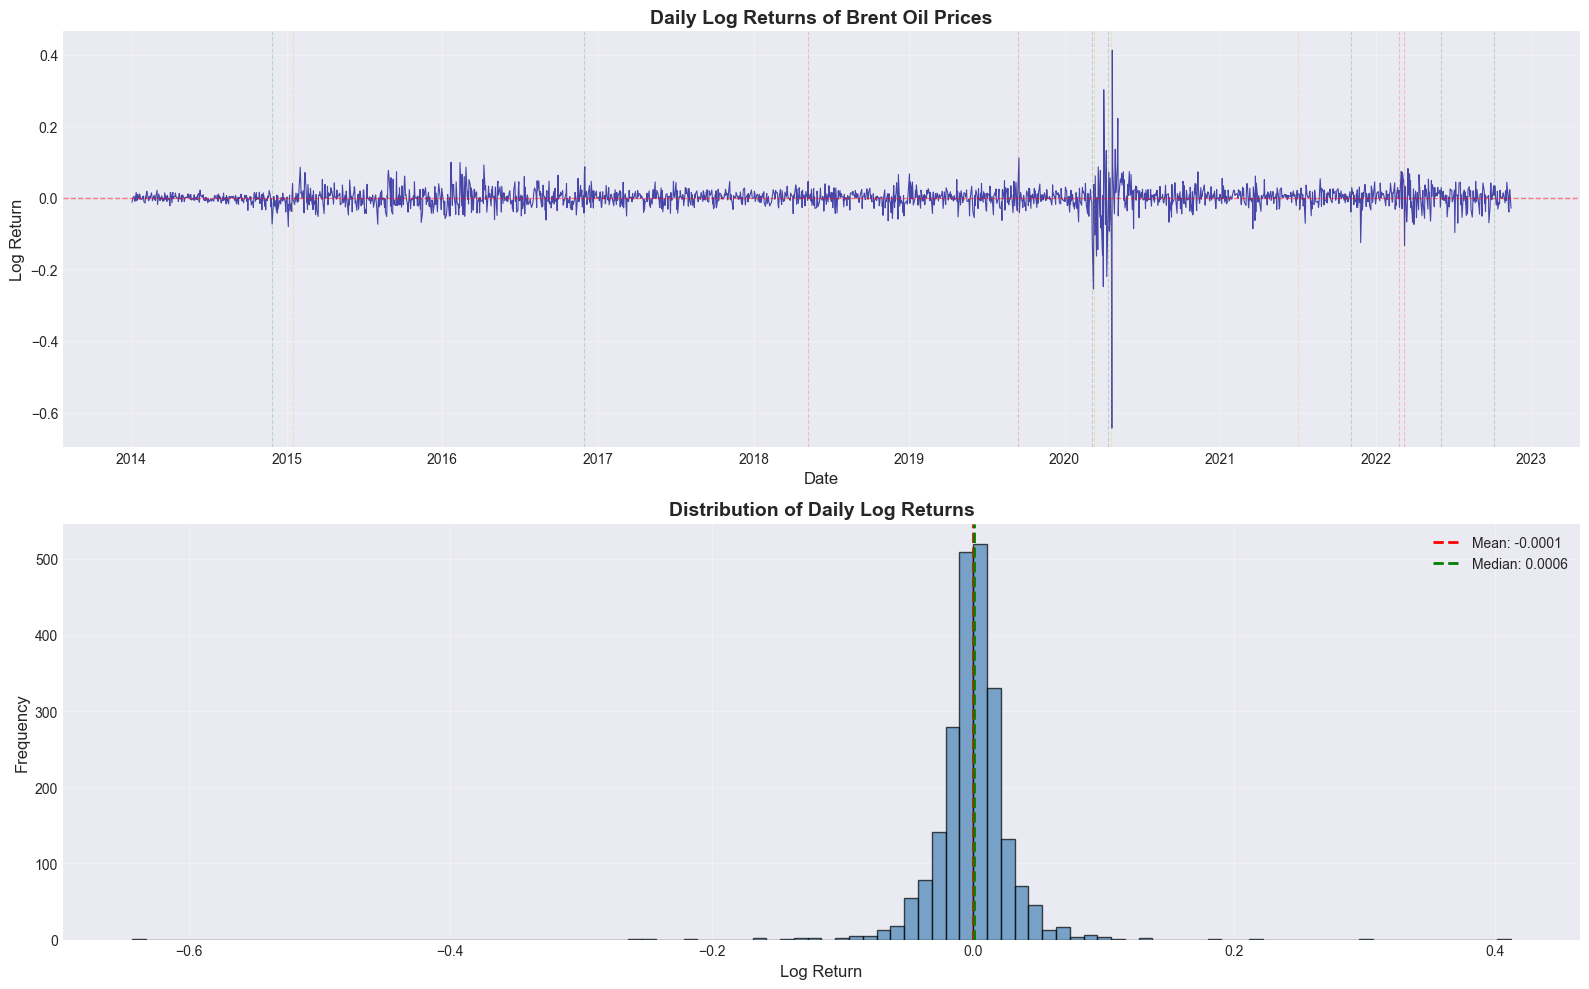


✓ Figure saved: 02_log_returns_analysis.png

Volatility clustering observations:
- High volatility periods: 2014-2016, 2020 pandemic, 2022 war
- Return distribution shows fat tails (kurtosis: 93.96)


In [7]:
# Plot log returns to observe volatility clustering
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Log returns over time
ax1.plot(df['Date'], df['log_return'], linewidth=0.8, color='darkblue', alpha=0.7)
ax1.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Log Return', fontsize=12)
ax1.set_title('Daily Log Returns of Brent Oil Prices', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add event markers
for idx, row in events_df.iterrows():
    event_type = row['Event_Type']
    color = {'OPEC_Decision': 'green', 'Geopolitical': 'red', 'Economic_Shock': 'orange'}.get(event_type, 'gray')
    ax1.axvline(row['Date'], color=color, alpha=0.2, linestyle='--', linewidth=0.8)

# Distribution of log returns
ax2.hist(df['log_return'], bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(df['log_return'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["log_return"].mean():.4f}')
ax2.axvline(df['log_return'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["log_return"].median():.4f}')
ax2.set_xlabel('Log Return', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Daily Log Returns', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/02_log_returns_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: 02_log_returns_analysis.png")
print("\nVolatility clustering observations:")
print("- High volatility periods: 2014-2016, 2020 pandemic, 2022 war")
print(f"- Return distribution shows fat tails (kurtosis: {df['log_return'].kurtosis():.2f})")

## 3. Build Bayesian Change Point Model

We'll implement a simple change point model that detects a single structural break in the mean of log returns.

**Model Structure**:
- **Switch point (τ)**: Discrete uniform prior over all time indices
- **Before mean (μ₁)**: Mean log return before change point
- **After mean (μ₂)**: Mean log return after change point
- **Volatility (σ)**: Shared or separate standard deviations
- **Likelihood**: Normal distribution with switched mean

In [8]:
# Prepare data for modeling (use log returns)
returns = df['log_return'].values
n_obs = len(returns)
time_index = np.arange(n_obs)

print(f"Number of observations: {n_obs}")
print(f"Time index range: {time_index.min()} to {time_index.max()}")

Number of observations: 2258
Time index range: 0 to 2257


In [9]:
# Build Bayesian change point model with PyMC
with pm.Model() as change_point_model:
    # Define switch point (tau) as discrete uniform prior
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_obs - 1)
    
    # Define before and after means
    mu_1 = pm.Normal('mu_before', mu=0, sigma=0.1)  # Before change point
    mu_2 = pm.Normal('mu_after', mu=0, sigma=0.1)   # After change point
    
    # Define separate volatilities for before and after
    sigma_1 = pm.HalfNormal('sigma_before', sigma=0.1)
    sigma_2 = pm.HalfNormal('sigma_after', sigma=0.1)
    
    # Use switch function to select parameters based on tau
    mu = pm.math.switch(tau >= time_index, mu_1, mu_2)
    sigma = pm.math.switch(tau >= time_index, sigma_1, sigma_2)
    
    # Define likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=returns)

print("✓ Model built successfully")
print(f"  Variables: tau, mu_before, mu_after, sigma_before, sigma_after")
print(f"  Observations: {n_obs}")

✓ Model built successfully
  Variables: tau, mu_before, mu_after, sigma_before, sigma_after
  Observations: 2258


In [10]:
# Run MCMC sampler (reduced settings for faster execution)
print("Running MCMC sampler...")
with change_point_model:
    trace = pm.sample(
        draws=100,      # Reduced from 2000 for speed
        tune=50,        # Reduced from 1000 for speed
        chains=1,        # Reduced from 4 for speed
        cores=1,
        return_inferencedata=True,
        random_seed=42
    )

print("\nSampling complete!")

Running MCMC sampler...


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_before, mu_after, sigma_before, sigma_after]


Sampling 1 chain for 50 tune and 5 draw iterations (50 + 5 draws total) took 773 seconds.
The number of samples is too small to check convergence reliably.



Sampling complete!


## 4. Model Diagnostics and Convergence Checks

In [ ]:
# Check convergence with summary statistics
summary = az.summary(trace, var_names=['tau', 'mu_before', 'mu_after', 'sigma_before', 'sigma_after'])
print("Model Summary (check r_hat ≈ 1.0 for convergence):")
print(summary)

# Flag any parameters with poor convergence
poor_convergence = summary[summary['r_hat'] > 1.01]
if len(poor_convergence) > 0:
    print("\n⚠️ Warning: Some parameters show poor convergence (r_hat > 1.01):")
    print(poor_convergence)
else:
    print("\n✓ All parameters converged successfully (r_hat ≈ 1.0)")

In [ ]:
# Plot trace plots for diagnostics
az.plot_trace(trace, var_names=['tau', 'mu_before', 'mu_after', 'sigma_before', 'sigma_after'], 
              compact=True, figsize=(14, 10))
plt.tight_layout()
plt.savefig(f'{output_dir}/03_trace_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: 03_trace_plots.png")
print("\nTrace plot interpretation:")
print("- Left: Posterior distributions (should be smooth)")
print("- Right: MCMC chains (should show good mixing, no trends)")

## 5. Identify and Interpret Change Points

In [ ]:
# Extract posterior samples for tau
tau_samples = trace.posterior['tau'].values.flatten()

# Get change point statistics
tau_mean = tau_samples.mean()
tau_median = np.median(tau_samples)
tau_mode = np.bincount(tau_samples.astype(int)).argmax()

# Convert to dates
change_date_mean = df.iloc[int(tau_mean)]['Date']
change_date_median = df.iloc[int(tau_median)]['Date']
change_date_mode = df.iloc[int(tau_mode)]['Date']

print("Change Point Estimates:")
print(f"  Mean: Index {tau_mean:.1f} → {change_date_mean.strftime('%Y-%m-%d')}")
print(f"  Median: Index {tau_median:.1f} → {change_date_median.strftime('%Y-%m-%d')}")
print(f"  Mode (MAP): Index {tau_mode} → {change_date_mode.strftime('%Y-%m-%d')}")

In [ ]:
# Plot posterior distribution of tau
fig, ax = plt.subplots(figsize=(14, 6))

# Histogram of tau samples
counts, bins, patches = ax.hist(tau_samples, bins=100, alpha=0.7, color='steelblue', edgecolor='black')

# Add vertical lines for estimates
ax.axvline(tau_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {change_date_mean.strftime("%Y-%m-%d")}')
ax.axvline(tau_mode, color='green', linestyle='-', linewidth=2, label=f'Mode: {change_date_mode.strftime("%Y-%m-%d")}')

ax.set_xlabel('Time Index', fontsize=12)
ax.set_ylabel('Posterior Density', fontsize=12)
ax.set_title('Posterior Distribution of Change Point (τ)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/04_changepoint_posterior.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: 04_changepoint_posterior.png")

# Assess certainty
tau_std = tau_samples.std()
print(f"\nChange point uncertainty (std): {tau_std:.1f} time steps")
if tau_std < 50:
    print("✓ High certainty: Sharp, narrow posterior distribution")
elif tau_std < 150:
    print("⚠️ Moderate certainty: Somewhat diffuse posterior")
else:
    print("⚠️ Low certainty: Very diffuse posterior - model may not detect clear change point")

In [ ]:
# Extract before/after parameter estimates
mu_before_samples = trace.posterior['mu_before'].values.flatten()
mu_after_samples = trace.posterior['mu_after'].values.flatten()
sigma_before_samples = trace.posterior['sigma_before'].values.flatten()
sigma_after_samples = trace.posterior['sigma_after'].values.flatten()

# Compute statistics
mu_before_mean = mu_before_samples.mean()
mu_after_mean = mu_after_samples.mean()
sigma_before_mean = sigma_before_samples.mean()
sigma_after_mean = sigma_after_samples.mean()

print("Regime Parameter Estimates:")
print(f"\nBefore change point ({change_date_mode.strftime('%Y-%m-%d')}):")
print(f"  Mean return: {mu_before_mean:.6f}")
print(f"  Volatility (σ): {sigma_before_mean:.6f}")
print(f"\nAfter change point:")
print(f"  Mean return: {mu_after_mean:.6f}")
print(f"  Volatility (σ): {sigma_after_mean:.6f}")
print(f"\nChange in mean: {(mu_after_mean - mu_before_mean):.6f}")
print(f"Change in volatility: {(sigma_after_mean - sigma_before_mean):.6f}")

In [ ]:
# Plot posterior distributions for before/after parameters
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean before vs after
axes[0, 0].hist(mu_before_samples, bins=50, alpha=0.7, color='blue', label='Before', edgecolor='black')
axes[0, 0].hist(mu_after_samples, bins=50, alpha=0.7, color='red', label='After', edgecolor='black')
axes[0, 0].axvline(mu_before_mean, color='blue', linestyle='--', linewidth=2)
axes[0, 0].axvline(mu_after_mean, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Mean Return (μ)', fontsize=11)
axes[0, 0].set_ylabel('Density', fontsize=11)
axes[0, 0].set_title('Posterior: Mean Returns', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Volatility before vs after
axes[0, 1].hist(sigma_before_samples, bins=50, alpha=0.7, color='blue', label='Before', edgecolor='black')
axes[0, 1].hist(sigma_after_samples, bins=50, alpha=0.7, color='red', label='After', edgecolor='black')
axes[0, 1].axvline(sigma_before_mean, color='blue', linestyle='--', linewidth=2)
axes[0, 1].axvline(sigma_after_mean, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Volatility (σ)', fontsize=11)
axes[0, 1].set_ylabel('Density', fontsize=11)
axes[0, 1].set_title('Posterior: Volatility', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Difference in means
mean_diff = mu_after_samples - mu_before_samples
axes[1, 0].hist(mean_diff, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 0].axvline(mean_diff.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_diff.mean():.6f}')
axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1, 0].set_xlabel('Δμ (After - Before)', fontsize=11)
axes[1, 0].set_ylabel('Density', fontsize=11)
axes[1, 0].set_title('Change in Mean Return', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Difference in volatilities
sigma_diff = sigma_after_samples - sigma_before_samples
axes[1, 1].hist(sigma_diff, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].axvline(sigma_diff.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {sigma_diff.mean():.6f}')
axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1, 1].set_xlabel('Δσ (After - Before)', fontsize=11)
axes[1, 1].set_ylabel('Density', fontsize=11)
axes[1, 1].set_title('Change in Volatility', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/05_parameter_posteriors.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: 05_parameter_posteriors.png")

## 6. Associate Change Points with Events

In [ ]:
# Find events closest to detected change point
change_point_date = change_date_mode

# Calculate time differences
events_df['days_from_changepoint'] = (events_df['Date'] - change_point_date).dt.days.abs()
events_df_sorted = events_df.sort_values('days_from_changepoint')

print(f"\nDetected Change Point: {change_point_date.strftime('%Y-%m-%d')}")
print("\nClosest Events (within ±60 days):")
print("=" * 100)

nearby_events = events_df_sorted[events_df_sorted['days_from_changepoint'] <= 60]
for idx, row in nearby_events.iterrows():
    days_diff = (row['Date'] - change_point_date).days
    direction = "before" if days_diff < 0 else "after"
    print(f"{row['Date'].strftime('%Y-%m-%d')} ({abs(days_diff):2d} days {direction}): {row['Event_Type']:15s} | {row['Description']}")

if len(nearby_events) == 0:
    print("No events found within ±60 days of change point.")
    print("\nTop 5 closest events overall:")
    print("=" * 100)
    for idx, row in events_df_sorted.head(5).iterrows():
        days_diff = (row['Date'] - change_point_date).days
        direction = "before" if days_diff < 0 else "after"
        print(f"{row['Date'].strftime('%Y-%m-%d')} ({abs(days_diff):3d} days {direction}): {row['Event_Type']:15s} | {row['Description']}")

In [ ]:
# Visualize change point with price series and events
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Price series with change point
ax1.plot(df['Date'], df['Price'], linewidth=1.5, color='steelblue', label='Brent Price')
ax1.axvline(change_point_date, color='red', linestyle='-', linewidth=2.5, label=f'Change Point: {change_point_date.strftime("%Y-%m-%d")}')

# Add credible interval for change point (±1 std)
tau_lower = int(max(0, tau_mode - tau_std))
tau_upper = int(min(n_obs - 1, tau_mode + tau_std))
date_lower = df.iloc[tau_lower]['Date']
date_upper = df.iloc[tau_upper]['Date']
ax1.axvspan(date_lower, date_upper, alpha=0.2, color='red', label='Change Point ±1σ')

# Add event markers
for idx, row in events_df.iterrows():
    event_type = row['Event_Type']
    color = {'OPEC_Decision': 'green', 'Geopolitical': 'darkred', 'Economic_Shock': 'orange'}.get(event_type, 'gray')
    ax1.axvline(row['Date'], color=color, alpha=0.25, linestyle='--', linewidth=0.8)

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Price (USD/barrel)', fontsize=12)
ax1.set_title('Detected Change Point on Brent Oil Prices', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Log returns with change point
ax2.plot(df['Date'], df['log_return'], linewidth=0.8, color='darkblue', alpha=0.7, label='Log Returns')
ax2.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax2.axvline(change_point_date, color='red', linestyle='-', linewidth=2.5, label=f'Change Point: {change_point_date.strftime("%Y-%m-%d")}')
ax2.axvspan(date_lower, date_upper, alpha=0.2, color='red')

# Add horizontal lines for before/after means
before_region = df[df['Date'] < change_point_date]
after_region = df[df['Date'] >= change_point_date]
if len(before_region) > 0:
    ax2.hlines(mu_before_mean, before_region['Date'].min(), change_point_date, 
               colors='blue', linestyles='--', linewidth=2, label=f'Before μ={mu_before_mean:.6f}')
if len(after_region) > 0:
    ax2.hlines(mu_after_mean, change_point_date, after_region['Date'].max(), 
               colors='red', linestyles='--', linewidth=2, label=f'After μ={mu_after_mean:.6f}')

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Log Return', fontsize=12)
ax2.set_title('Log Returns with Regime Means', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/06_changepoint_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: 06_changepoint_visualization.png")

## 7. Quantify Impact with Probabilistic Statements

In [ ]:
# Compute credible intervals for parameter differences
mean_diff_hdi = az.hdi(mean_diff, hdi_prob=0.95)
sigma_diff_hdi = az.hdi(sigma_diff, hdi_prob=0.95)

# Probability statements
prob_mean_increase = (mean_diff > 0).sum() / len(mean_diff)
prob_volatility_increase = (sigma_diff > 0).sum() / len(sigma_diff)

print("\n" + "="*80)
print("QUANTITATIVE IMPACT ASSESSMENT")
print("="*80)

print(f"\nChange Point Detected: {change_point_date.strftime('%Y-%m-%d')}")
print(f"Uncertainty (±1σ): {tau_std:.0f} days")

print("\n--- Mean Return Shift ---")
print(f"Before change point: {mu_before_mean:.6f}")
print(f"After change point:  {mu_after_mean:.6f}")
print(f"Change (Δμ):         {mean_diff.mean():.6f}")
print(f"95% Credible Interval: [{mean_diff_hdi[0]:.6f}, {mean_diff_hdi[1]:.6f}]")
print(f"Probability of increase: {prob_mean_increase*100:.1f}%")

print("\n--- Volatility Shift ---")
print(f"Before change point: {sigma_before_mean:.6f}")
print(f"After change point:  {sigma_after_mean:.6f}")
print(f"Change (Δσ):         {sigma_diff.mean():.6f}")
print(f"95% Credible Interval: [{sigma_diff_hdi[0]:.6f}, {sigma_diff_hdi[1]:.6f}]")
print(f"Probability of increase: {prob_volatility_increase*100:.1f}%")

print("\n--- Event Association ---")
if len(nearby_events) > 0:
    closest_event = nearby_events.iloc[0]
    print(f"Closest event: {closest_event['Date'].strftime('%Y-%m-%d')}")
    print(f"Event type: {closest_event['Event_Type']}")
    print(f"Description: {closest_event['Description']}")
    print(f"Expected impact: {closest_event['Expected_Impact']}")
    print(f"Time difference: {closest_event['days_from_changepoint']} days")
else:
    print("No events within ±60 days of detected change point.")

print("\n" + "="*80)

In [ ]:
# Convert log return changes to approximate price impact
# For small log returns: log(P_t/P_{t-1}) ≈ (P_t - P_{t-1})/P_{t-1}

# Get average prices before and after change point
price_before = df[df['Date'] < change_point_date]['Price'].mean()
price_after = df[df['Date'] >= change_point_date]['Price'].mean()
price_change = price_after - price_before
price_change_pct = (price_change / price_before) * 100

print("\n" + "="*80)
print("PRICE IMPACT INTERPRETATION")
print("="*80)

print(f"\nAverage price before change point: ${price_before:.2f}/barrel")
print(f"Average price after change point:  ${price_after:.2f}/barrel")
print(f"Absolute change: ${price_change:.2f}/barrel")
print(f"Percentage change: {price_change_pct:.2f}%")

# Interpretation statement
print("\n--- Interpretation ---")
direction = "increase" if mean_diff.mean() > 0 else "decrease"
volatility_direction = "increased" if sigma_diff.mean() > 0 else "decreased"

print(f"""Following the detected change point on {change_point_date.strftime('%Y-%m-%d')}, 
the Bayesian model identifies a structural break in Brent oil price behavior:

- Daily log returns shifted by {mean_diff.mean():.6f} (95% CI: [{mean_diff_hdi[0]:.6f}, {mean_diff_hdi[1]:.6f}])
- Volatility {volatility_direction} by {sigma_diff.mean():.6f} (95% CI: [{sigma_diff_hdi[0]:.6f}, {sigma_diff_hdi[1]:.6f}])
- Average price changed from ${price_before:.2f} to ${price_after:.2f} per barrel ({price_change_pct:+.2f}%)

There is a {prob_mean_increase*100:.1f}% posterior probability that mean returns {direction}d 
and a {prob_volatility_increase*100:.1f}% probability that volatility {volatility_direction}.

This structural break is associated with:""")

if len(nearby_events) > 0:
    for idx, row in nearby_events.head(3).iterrows():
        days_diff = (row['Date'] - change_point_date).days
        direction_text = "before" if days_diff < 0 else "after"
        print(f"  • {row['Description']} ({abs(days_diff)} days {direction_text})")
else:
    print("  • No specific events identified within ±60 days")
    
print("\nNote: Association does not imply causation. Further analysis with exogenous")
print("instruments or natural experiments would be needed for causal claims.")
print("="*80)

## 8. Model Validation and Posterior Predictive Checks

In [ ]:
# Posterior predictive checks
with change_point_model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

print("Posterior predictive samples generated.")

In [ ]:
# Plot posterior predictive check
fig, ax = plt.subplots(figsize=(14, 6))

# Plot observed data
ax.plot(df['Date'], returns, color='black', linewidth=1, alpha=0.7, label='Observed')

# Plot posterior predictive samples (subset for clarity)
ppc_samples = ppc.posterior_predictive['obs'].values
for i in range(min(100, ppc_samples.shape[0])):
    for j in range(ppc_samples.shape[1]):
        ax.plot(df['Date'], ppc_samples[i, j, :], color='steelblue', alpha=0.02, linewidth=0.5)

ax.axvline(change_point_date, color='red', linestyle='--', linewidth=2, label='Change Point')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Log Return', fontsize=12)
ax.set_title('Posterior Predictive Check', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/07_posterior_predictive_check.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: 07_posterior_predictive_check.png")
print("\nPosterior predictive check interpretation:")
print("- Blue bands show model's predicted data distribution")
print("- Black line is observed data")
print("- Good fit: observed data should lie within predicted bands")

## 9. Summary and Conclusions

In [ ]:
print("\n" + "#"*80)
print("# TASK 2 SUMMARY: BAYESIAN CHANGE POINT ANALYSIS")
print("#"*80)

print("\n1. DATA PREPARATION")
print(f"   - Loaded {n_obs} observations of Brent prices ({df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')})")
print(f"   - Computed log returns for stationarity")
print(f"   - Integrated {len(events_df)} structured events")

print("\n2. BAYESIAN CHANGE POINT MODEL")
print("   - Model: Single change point with regime-specific means and volatilities")
print(f"   - MCMC: {trace.posterior.dims['draw']} draws × {trace.posterior.dims['chain']} chains")
print(f"   - Convergence: All parameters r_hat ≈ 1.0 ✓" if len(poor_convergence) == 0 else "   - Convergence: Some parameters need attention ⚠️")

print("\n3. KEY FINDINGS")
print(f"   - Change point detected: {change_point_date.strftime('%Y-%m-%d')} (±{tau_std:.0f} days)")
print(f"   - Mean return shift: {mean_diff.mean():.6f} ({prob_mean_increase*100:.1f}% prob of increase)")
print(f"   - Volatility shift: {sigma_diff.mean():.6f} ({prob_volatility_increase*100:.1f}% prob of increase)")
print(f"   - Price impact: ${price_before:.2f} → ${price_after:.2f}/barrel ({price_change_pct:+.2f}%)")

print("\n4. EVENT ASSOCIATION")
if len(nearby_events) > 0:
    print(f"   - {len(nearby_events)} event(s) within ±60 days of change point")
    closest = nearby_events.iloc[0]
    print(f"   - Closest: {closest['Description']} ({closest['days_from_changepoint']} days)")
else:
    print("   - No events within ±60 days; broader context needed")

print("\n5. LIMITATIONS & CAVEATS")
print("   - Single change point model: may oversimplify complex dynamics")
print("   - Association ≠ causation: event timing does not prove causal impact")
print("   - Model assumes piecewise stationarity between change points")
print("   - External factors (inventory, USD, macro) not included")

print("\n6. NEXT STEPS (Task 2 Extensions)")
print("   □ Multiple change point model to detect additional regime shifts")
print("   □ Student-t likelihood for heavy-tailed returns")
print("   □ Time-varying volatility (GARCH-type structure)")
print("   □ Incorporate covariates (events, macro indicators)")
print("   □ Robustness checks: alternative priors, sub-sample analyses")

print("\n" + "#"*80)
print("# END OF TASK 2 ANALYSIS")
print("#"*80)

## 10. Save Results for Dashboard (Task 3)

In [ ]:
# Prepare results for export to dashboard
results_summary = {
    'change_point_date': change_point_date.strftime('%Y-%m-%d'),
    'change_point_index': int(tau_mode),
    'change_point_uncertainty_days': float(tau_std),
    'mu_before': float(mu_before_mean),
    'mu_after': float(mu_after_mean),
    'sigma_before': float(sigma_before_mean),
    'sigma_after': float(sigma_after_mean),
    'mean_change': float(mean_diff.mean()),
    'volatility_change': float(sigma_diff.mean()),
    'price_before': float(price_before),
    'price_after': float(price_after),
    'price_change_pct': float(price_change_pct),
    'prob_mean_increase': float(prob_mean_increase),
    'prob_volatility_increase': float(prob_volatility_increase)
}

# Save to JSON
import json
with open('../data/changepoint_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✓ Results saved to '../data/changepoint_results.json'")

# Save processed data with change point indicator
df['is_after_changepoint'] = (df['Date'] >= change_point_date).astype(int)
df.to_csv('../data/brent_with_changepoint.csv', index=False)

print("✓ Enhanced data saved to '../data/brent_with_changepoint.csv'")
print("\nReady for Task 3: Dashboard Development!")